In [1]:
import pandas as pd 
import math
import numpy as np
import matplotlib.pyplot as plt

# load dataframes from CSV files 
from data.load_csv import orig_tournament_df, orig_bout_df, orig_fencer_bio_df, orig_fencer_rankings_df

# copy dataframes for cleanup 
tournament_df, bout_df, fencer_bio_df, fencer_rankings_df = \
    orig_tournament_df.copy(), orig_bout_df.copy(), orig_fencer_bio_df.copy(), orig_fencer_rankings_df.copy()

# Initial Examination of Missing Fields

Checking where missing (NaN) values occur in the dataframes to see where to investigate


In [2]:
list_of_df = [tournament_df, bout_df, fencer_bio_df, fencer_rankings_df]
for df in list_of_df:
    df._metadata += ['df_name']
    print("")
    print(df.df_name)
    print("")
    print("Columns: {}".format(list(df.columns)))
    print("  Row Count: {}".format(df.shape[0]))
    print("  Column Count: {}".format(df.shape[1]))


Tournament Dataframe

Columns: ['competition_ID', 'season', 'name', 'category', 'country', 'start_date', 'end_date', 'weapon', 'gender', 'timezone', 'url', 'unique_ID', 'missing_results_flag']
  Row Count: 830
  Column Count: 13

Bouts Dataframe

Columns: ['fencer_ID', 'opp_ID', 'fencer_age', 'opp_age', 'fencer_score', 'opp_score', 'winner_ID', 'fencer_curr_pts', 'opp_curr_pts', 'tournament_ID', 'pool_ID', 'upset', 'date']
  Row Count: 49137
  Column Count: 13

Fencer Bio Dataframe

Columns: ['id', 'name', 'country_code', 'country', 'hand', 'age', 'url', 'date_accessed']
  Row Count: 2122
  Column Count: 8

Fencer Rankings Dataframe

Columns: ['rank', 'points']
  Row Count: 10941
  Column Count: 2


In [3]:
list_of_df = [tournament_df, bout_df, fencer_bio_df, fencer_rankings_df]
for df in list_of_df:
    print("")
    print(df.df_name)
    print("")

    print("Missing Values:",end="")
    if(df.isna().sum().sum() > 0):
        print("")
        print(df.isna().sum()[df.isna().sum() > 0])
    else:
        print("   None!")


Tournament Dataframe

Missing Values:
missing_results_flag    218
dtype: int64

Bouts Dataframe

Missing Values:   None!

Fencer Bio Dataframe

Missing Values:
country_code    1
country         1
hand            2
dtype: int64

Fencer Rankings Dataframe

Missing Values:   None!


### Conclusions

* Tournament Dataframe's missing values correspond to empty missing_results_flags which just means the tournament does have bout data, not a problem! 

* Fencer Bio Dataframe missing values (hand:2, country/country code:1) should be invesitgated. 

# Cleaning Up Fencer Data




### Count fencers in each dataframe

In [4]:
fencer_ID_list = list(set(list(np.unique(bout_df['fencer_ID'])) + list(np.unique(bout_df['opp_ID']))))
print("Number of unique fencers in any bout:           {}".format(len(fencer_ID_list)))
print("Number of rows in the bio dataframe:            {}".format(fencer_bio_df.shape[0]))
print("Number of unique fencers in bio dataframe:      {}".format(len(list(np.unique(fencer_bio_df['id'])))))
print("Number of unique fencers in rankings dataframe: {}".format(np.unique(fencer_rankings_df.index.get_level_values(0)).size))

Number of unique fencers in any bout:           2109
Number of rows in the bio dataframe:            2122
Number of unique fencers in bio dataframe:      2122
Number of unique fencers in rankings dataframe: 2031


In [5]:
def remove_fencers_from_bout(ID_list):
    init_rows = bout_df.shape[0]
    indices_to_drop = bout_df[(bout_df['fencer_ID'].isin(ID_list)) | (bout_df['opp_ID'].isin(ID_list))].index
    bout_df.drop(index=indices_to_drop, inplace=True)
    final_rows = bout_df.shape[0]
    print("Removed fencers from bout_df with IDS: {}".format(ID_list))
    print("   Number of Rows removed: {}".format(init_rows-final_rows))

def remove_fencers_from_bio(ID_list):
    init_rows = fencer_bio_df.shape[0]
    indices_to_drop = fencer_bio_df[fencer_bio_df['id'].isin(ID_list)]['id'].index
    fencer_bio_df.drop(index=indices_to_drop, inplace=True)
    final_rows = fencer_bio_df.shape[0]
    print("Removed fencers from fencer_bio_df with IDS: {}".format(ID_list))
    print("   Number of Rows removed: {}".format(init_rows-final_rows))

def remove_fencers_from_rankings(ID_list):
    init_fencers = np.unique(fencer_rankings_df.index.get_level_values(0)).size
    init_rows = fencer_rankings_df.shape[0]
    fencer_rankings_df.drop(ID_list, level='id', inplace=True, errors='ignore') 
    final_fencers = np.unique(fencer_rankings_df.index.get_level_values(0)).size
    final_rows = fencer_rankings_df.shape[0]
    print("Removed fencers from fencer_rankings_df with IDS: {}".format(ID_list))
    print("   Number of fencers/rows removed: {}/{}".format(init_fencers-final_fencers,init_rows-final_rows))

### Explore Missing Bio Data

Look into the fencers with missing bio data and decide how to handle them. 

In [6]:
# Review missing data for fencer_bio_df
print(fencer_bio_df.df_name)
fencer_bio_df.isna().sum()

Fencer Bio Dataframe


id               0
name             0
country_code     1
country          1
hand             2
age              0
url              0
date_accessed    0
dtype: int64

In [7]:
# pull up the rows with the missing data ('hand' suffices since this gets all NaNs)
fencer_bio_df[fencer_bio_df['hand'].isna()]

,id,name,country_code,country,hand,age,url,date_accessed
400,18867,KIM Yoonha,KOR,KOREA,NaN,31,https://fie.org/athletes/18867,2021-05-13 21:33:17
1927,1414,AGUERO Es,NaN,NaN,NaN,-,https://fie.org/athletes/1414,2021-05-13 21:24:48


Fencer with ID 18867 has all data except hand and can be safely included. 

Fencer with ID 1414 has only name data... 

...reviewing the data creation process from fie-fencing-dataset and FIE pages, this comes from a missing athelete page/reused ID on the FIE website. 

In [8]:
# count number of bouts lost by excluding ID 1414 (ANS = 6) 
bout_df[(bout_df['fencer_ID']==1414) | (bout_df['opp_ID']==1414)]

,fencer_ID,opp_ID,fencer_age,opp_age,fencer_score,opp_score,winner_ID,fencer_curr_pts,opp_curr_pts,tournament_ID,pool_ID,upset,date
9029,8184,1414,61,55,5,3,8184,0.0,0.0,2015-1105,2,False,2015-10-20
9034,31422,1414,59,55,4,3,31422,0.0,0.0,2015-1105,2,False,2015-10-20
9039,1414,35696,55,57,1,5,35696,0.0,0.0,2015-1105,2,False,2015-10-20
9040,1414,31372,55,62,5,2,1414,0.0,0.0,2015-1105,2,False,2015-10-20
9041,1414,38923,55,60,0,5,38923,0.0,0.0,2015-1105,2,False,2015-10-20
9042,1414,33457,55,58,2,5,33457,0.0,0.0,2015-1105,2,False,2015-10-20


In [9]:
# remove fencers with ID 1414 from bouts, bio data df, and rankings data
remove_fencers_from_bio([1414])
remove_fencers_from_bout([1414])
remove_fencers_from_rankings([1414])

Removed fencers from fencer_bio_df with IDS: [1414]
   Number of Rows removed: 1
Removed fencers from bout_df with IDS: [1414]
   Number of Rows removed: 6
Removed fencers from fencer_rankings_df with IDS: [1414]
   Number of fencers/rows removed: 0/0


In [10]:
# Verify that no rows in these DF have ID 1414
# print("Rows in bout_df with ID 1414:            {}".format(bout_df[(bout_df['fencer_ID']==1414) | (bout_df['opp_ID']==1414)].shape[0]))
count = bout_df[(bout_df['fencer_ID']==1414) | (bout_df['opp_ID']==1414)].shape[0]
assert count == 0, "Warning: Bouts remain with fencer 1414"
print("Succesfully removed all bout rows with fencer 1414")
# print("Rows in fencer_bio_df with ID 1414:      {}".format(fencer_bio_df[fencer_bio_df['id'] == 1414].shape[0]))
count = fencer_bio_df[fencer_bio_df['id'] == 1414].shape[0]
assert count == 0, "Warning: Bios remain with fencer 1414"
print("Succesfully removed all fencer_bio rows with fencer 1414")
# print("Rows in fencer_rankings_df with ID 1414: {}".format(list(fencer_rankings_df.index.get_level_values(0)).count(1414)))
count = list(fencer_rankings_df.index.get_level_values(0)).count(1414)
assert count == 0, "Warning: Rankings remain with fencer 1414"
print("Succesfully removed all fencer_rankings rows with fencer 1414")

Succesfully removed all bout rows with fencer 1414
Succesfully removed all fencer_bio rows with fencer 1414
Succesfully removed all fencer_rankings rows with fencer 1414


### Conclusions 

**Fencer (18867) Fine** 

Only hand data missing here so can be kept in the dataset.

**Remove Fencer (1414) with All Bio Data Missing**

Fencer with id 141 has no data and will be excluded from the dataset 

  --> removed all bouts with this fencer from the bouts dataframe as well (only 6 bouts are lost)

Note: This error in the dataset comes directly from the FIE website, where the ID *was* affiliated with a fencer (HENNIG Bonnie) in [this tournament](https://fie.org/competitions/2015/1105) but the fencer's [page](https://fie.org/athletes/1414) now has a stub with a different name (AGUERO Es) and no bio data and does not show up in the athlete [search](https://fie.org/athletes/search). 


### Remove fencers with no bout data

Some fencers in the fencer_bio_df and fencer_rankings_df do not have any bouts in the bout_df. These can be removed from fencer_bio_df and fencer_rankings_df since we only want fencers for which we have bout data. 

Fencer IDs can show up for fencers who were registered for the tournament and thus showed up in the tournaments athlete list but did not fence in the event (and thus have no pools data). 

Example: https://fie.org/competitions/2015/125 for fencer Pineda (ID 13089)

In [11]:
print("IDs for fencers in bio dataframe not associated with any bout:\n   ",end="")
fencers_with_no_bouts = list(set(np.unique(fencer_bio_df['id'])) - set(fencer_ID_list))
fencers_with_no_bouts.sort()
print(fencers_with_no_bouts)

IDs for fencers in bio dataframe not associated with any bout:
   [13089, 38010, 42617, 46276, 46378, 46847, 47863, 49319, 49966, 50852, 51726, 52917, 53150]


In [12]:
# double check no bouts for these fencers 
for fencer_id in fencers_with_no_bouts:
    df = bout_df[(bout_df['fencer_ID'] == fencer_id) | (bout_df['opp_ID'] == fencer_id)]
    assert df.shape[0] == 0, "Failed to remove fencer with ID {} from bout_df".format(fencer_id)

print("Confirmed no bouts for fencers in list!")

Confirmed no bouts for fencers in list!


In [13]:
# print out the fencers who are missing bout data
fencer_bio_df[fencer_bio_df['id'].isin(fencers_with_no_bouts)]

,id,name,country_code,country,hand,age,url,date_accessed
797,51726,BLEIER Raluca,ROU,ROMANIA,Right,19,https://fie.org/athletes/51726,2021-05-13 21:33:37
944,38010,CHEN Alyssa,USA,USA,Left,21,https://fie.org/athletes/38010,2021-05-13 21:46:47
968,46276,AMADO Clara,ESP,SPAIN,Right,20,https://fie.org/athletes/46276,2021-05-13 21:47:25
992,46378,CASTRO Marta,ESP,SPAIN,Right,21,https://fie.org/athletes/46378,2021-05-13 21:47:48
1085,42617,NICOLLEAU Roseline Celeste,ESP,SPAIN,Right,22,https://fie.org/athletes/42617,2021-05-13 21:25:34
1109,52917,LOPES BENTO Hadija Fernanda,CPV,CAPE VERDE,Right,15,https://fie.org/athletes/52917,2021-05-13 21:40:00
1403,13089,PINEDA Joselina,VEN,VENEZUELA,Right,38,https://fie.org/athletes/13089,2021-05-13 21:45:10
1488,49319,BOEGLE Vivien,AUT,AUSTRIA,Right,19,https://fie.org/athletes/49319,2021-05-13 21:20:09
1920,53150,KARRI Gowri,IND,INDIA,Right,16,https://fie.org/athletes/53150,2021-05-13 21:41:16
1943,50852,WULF Annette,GER,GERMANY,Left,52,https://fie.org/athletes/50852,2021-05-13 21:25:51


In [14]:
# remove fencers with no bouts from bio/rankings df (double check that 0 rows removed from bout_df)
remove_fencers_from_bio(fencers_with_no_bouts)
remove_fencers_from_bout(fencers_with_no_bouts)
remove_fencers_from_rankings(fencers_with_no_bouts)

Removed fencers from fencer_bio_df with IDS: [13089, 38010, 42617, 46276, 46378, 46847, 47863, 49319, 49966, 50852, 51726, 52917, 53150]
   Number of Rows removed: 13
Removed fencers from bout_df with IDS: [13089, 38010, 42617, 46276, 46378, 46847, 47863, 49319, 49966, 50852, 51726, 52917, 53150]
   Number of Rows removed: 0
Removed fencers from fencer_rankings_df with IDS: [13089, 38010, 42617, 46276, 46378, 46847, 47863, 49319, 49966, 50852, 51726, 52917, 53150]
   Number of fencers/rows removed: 2/4


In [15]:
# check that no bio/ranking IDs remain with no bout data
assert fencer_bio_df[fencer_bio_df['id'].isin(fencers_with_no_bouts)].size == 0, \
    "Failed to remove all fencers without bouts from fencer_bio_df"
print("Successfully removed all fencers without bout data from fencer_bio_df!")

assert len([i for i in list(fencer_rankings_df.index.get_level_values(0)) if i in fencers_with_no_bouts]) == 0, \
    "Failed to remove all fencers without bouts from fencer_rankings_df"
print("Successfully removed all fencers without bout data from fencer_rankings_df!")

Successfully removed all fencers without bout data from fencer_bio_df!
Successfully removed all fencers without bout data from fencer_rankings_df!


In [16]:
fencer_ID_list_from_bouts = list(set(list(np.unique(bout_df['fencer_ID'])) + list(np.unique(bout_df['opp_ID']))))
print("Number of unique fencers in any bout:           {}".format(len(fencer_ID_list_from_bouts)))
print("Number of rows in the bio dataframe:            {}".format(fencer_bio_df.shape[0]))
print("Number of unique fencers in bio dataframe:      {}".format(len(list(np.unique(fencer_bio_df['id'])))))
print("Number of unique fencers in rankings dataframe: {}".format(np.unique(fencer_rankings_df.index.get_level_values(0)).size))

Number of unique fencers in any bout:           2108
Number of rows in the bio dataframe:            2108
Number of unique fencers in bio dataframe:      2108
Number of unique fencers in rankings dataframe: 2029


In [17]:
# get list of IDs with bouts
fencer_ID_list_from_bouts = list(set(list(np.unique(bout_df['fencer_ID'])) + list(np.unique(bout_df['opp_ID']))))
fencer_ID_list_from_bouts.sort()
# get list of IDs with bio info
fencer_ID_list_from_bios = list(np.unique(fencer_bio_df['id']))
fencer_ID_list_from_bios.sort()
# check these lists match 
assert fencer_ID_list_from_bios == fencer_ID_list_from_bouts, "Mismatch between fencer list from bios and bouts"
print("Success! Fencer ID lists from bout_df and fencer_bio_df match!")

Success! Fencer ID lists from bout_df and fencer_bio_df match!


### Conclusions 

Removed fencers with no bout data from fencer_bio_df and fencer_rankings_df 

### Explore fencers with no rankings data

Unique fencers with rankings data is 2029 compared to 2108 fencers with bout & bio data. 

Look into how many bouts they represent from bout_df

In [18]:
missing_fencer_rankings = list(set(np.unique(fencer_bio_df['id'])) - set(np.unique(fencer_rankings_df.index.get_level_values(0))))
print("Fencer IDs with bout/bio data but no rankings info: (count = {})".format(len(missing_fencer_rankings)))
print(missing_fencer_rankings)

Fencer IDs with bout/bio data but no rankings info: (count = 79)
[3072, 33287, 48135, 6672, 43030, 48150, 48163, 48166, 33327, 36404, 50741, 46134, 50742, 11319, 33343, 50755, 48196, 50760, 8790, 34907, 48220, 40033, 40545, 47717, 43125, 43130, 50304, 47750, 51852, 25741, 43155, 50842, 27806, 8864, 50851, 38575, 38065, 27827, 27833, 41661, 44228, 31455, 38641, 48881, 37621, 25850, 38650, 42746, 43267, 14611, 50995, 35636, 50997, 36150, 50999, 3384, 47930, 47932, 50514, 47964, 2918, 47986, 46971, 51070, 17799, 51082, 48011, 48012, 51109, 11201, 48075, 53200, 38868, 3029, 48086, 48104, 1006, 43510, 8184]


In [19]:
fencer_bio_df[fencer_bio_df['id'].isin(missing_fencer_rankings)]

,id,name,country_code,country,hand,age,url,date_accessed
201,34907,ELSHARKAWY Hadil,EGY,EGYPT,Right,23,https://fie.org/athletes/34907,2021-05-13 21:31:23
515,37621,SANTHOSH GEETHA Aarcha,IND,INDIA,Left,23,https://fie.org/athletes/37621,2021-05-13 21:44:56
570,50304,SUTAR Jyoti Arun,IND,INDIA,Right,22,https://fie.org/athletes/50304,2021-05-13 21:23:55
603,50514,SAFARIC Tina,SLO,SLOVENIA,Right,22,https://fie.org/athletes/50514,2021-05-13 21:24:41
641,33327,UFF Susan,GBR,GREAT BRITAIN,Left,72,https://fie.org/athletes/33327,2021-05-13 21:21:10
...,...,...,...,...,...,...,...,...
1993,38641,VALLET-MODAINE Laurence,FRA,FRANCE,Right,56,https://fie.org/athletes/38641,2021-05-13 21:49:09
1996,38650,DRESEN-KUCHALSKI Margaretha,GER,GERMANY,Left,62,https://fie.org/athletes/38650,2021-05-13 21:49:11
1997,51070,LANSKOVA Maya,RUS,RUSSIA,Right,52,https://fie.org/athletes/51070,2021-05-13 21:30:21
2013,53200,VICTORIA Andrea,PAN,PANAMA,Left,19,https://fie.org/athletes/53200,2021-05-13 21:41:27


In [20]:
# count bouts corresponding to these fencers (bout_df rows = 49131)
count = bout_df[(bout_df['fencer_ID'].isin(missing_fencer_rankings)) | (bout_df['opp_ID'].isin(missing_fencer_rankings)) ].shape[0]
print("Bouts corresponding to fencers with no rankings data: {} ({:.2%} of total bouts)".format(count, count/bout_df.shape[0]))

Bouts corresponding to fencers with no rankings data: 563 (1.15% of total bouts)


In [21]:
# # Remove fencers without rankings from bouts and bio dataframes
# remove_fencers_from_bio(missing_fencer_rankings)
# remove_fencers_from_bout(missing_fencer_rankings)
# remove_fencers_from_rankings(missing_fencer_rankings)

In [22]:
# # SCRIPT TO CHECK IF FENCERS WITH RANKINGS MATCHES FENCERS WITH BOUTS (optional)
# # get list of IDs with bouts
# fencer_ID_list_from_bouts = list(set(list(np.unique(bout_df['fencer_ID'])) + list(np.unique(bout_df['opp_ID']))))
# fencer_ID_list_from_bouts.sort()
# # get list of IDs with bio info
# fencer_ID_list_from_rankings = list(np.unique(fencer_rankings_df.index.get_level_values(0)))
# fencer_ID_list_from_rankings.sort()
# # check these lists match 
# assert fencer_ID_list_from_bios == fencer_ID_list_from_rankings, "Mismatch between fencer list from bouts and rankings"
# print("Success! Fencer ID lists from bout_df and fencer_bio_df match!")

### Conclusions 

About ~1.15% of bouts would be lost by removing these fencer. For now will keep but if this becomes problematic for data analysis later on, could consider  coming back and removing these. 

To remove and check removed uncomment and run the 2 immediately preceeding cells. 

### Review Nationality Data

Check nationality/country list and look for any inconsistencies there

In [23]:
## Nationality - count unique countries
len(list(np.unique(fencer_bio_df['country'])))

101

In [24]:
fencer_bio_df.groupby('country').count().sort_values(by=['id'],ascending=False)

,id,name,country_code,hand,age,url,date_accessed
country,,,,,,,
USA,131,131,131,131,131,131,131
ITALY,130,130,130,130,130,130,130
GERMANY,113,113,113,113,113,113,113
FRANCE,88,88,88,88,88,88,88
GREAT BRITAIN,87,87,87,87,87,87,87
...,...,...,...,...,...,...,...
SAUDI ARABIA,1,1,1,1,1,1,1
BOTSWANA,1,1,1,1,1,1,1
DEMOCRATIC REPUBLIC OF CONGO,1,1,1,1,1,1,1


In [25]:
# check fencers whose 'country' name seems to be the country code  
fencer_bio_df[fencer_bio_df['country'].apply(lambda x: len(x) < 3)]
# confirmed, code=name so not getting translated into country 

,id,name,country_code,country,hand,age,url,date_accessed
408,47552,AUNG Phyu Phyu,MM,MM,Right,24,https://fie.org/athletes/47552,2021-05-13 21:51:57
409,47553,SOE Nan Ei,MM,MM,Right,19,https://fie.org/athletes/47553,2021-05-13 21:51:58
1373,51548,MEJIA LOPEZ Angie Fabiola,HN,HN,Right,16,https://fie.org/athletes/51548,2021-05-13 21:32:58
1772,39056,LOPEZ FLORES Kateryn Gissel,HN,HN,Right,24,https://fie.org/athletes/39056,2021-05-13 21:50:39
1807,40178,ALBUAINAIN Sumaya,BH,BH,Right,19,https://fie.org/athletes/40178,2021-05-13 21:54:32
1808,40179,ALI Muna,BH,BH,Right,24,https://fie.org/athletes/40179,2021-05-13 21:54:32
1809,40180,FARDEEN Layla,BH,BH,Right,19,https://fie.org/athletes/40180,2021-05-13 21:54:42
1810,40181,MOHAMED Maram,BH,BH,Right,19,https://fie.org/athletes/40181,2021-05-13 21:54:38
1915,46850,LIANG Jenny,AS,AS,Right,18,https://fie.org/athletes/46850,2021-05-13 21:49:13
2034,41583,CLARE Alana,BS,BS,Right,26,https://fie.org/athletes/41583,2021-05-13 21:21:46


In [26]:
# count number of countries affected 
count = fencer_bio_df[fencer_bio_df['country'].apply(lambda x: len(x) < 3)].groupby('country').count().shape[0]
print("Number of countries with missing country names: {}".format(count))
missing_country_name_list = fencer_bio_df[fencer_bio_df['country'].apply(lambda x: len(x) < 3)].groupby('country').count().index
print("Country codes with no country names: \n   {}".format(list(missing_country_name_list)))

Number of countries with missing country names: 6
Country codes with no country names: 
   ['AS', 'BH', 'BS', 'HN', 'LK', 'MM']


By checking the fencer's webpages and identifying flags, here are the missing country names: 

* AS = AMERICAN SAMOA
* BH = BAHRAIN
* BS = BAHAMAS
* HN = HONDURAS
* LK = SRI LANKA
* MM = MYANMAR

In [27]:
country_code_to_name_dict = {'AS': 'AMERICAN SAMOA', 'BH': 'BAHRAIN', 'BS': 'BAHAMAS', 
                             'HN': 'HONDURAS', 'LK': 'SRI LANKA',  'MM': 'MYANMAR'}
fencer_bio_df['country'] = fencer_bio_df['country'].replace(country_code_to_name_dict)

In [28]:
assert fencer_bio_df[fencer_bio_df['country'].apply(lambda x: len(x) < 3)].shape[0] == 0, \
    "Some country codes remaining"
print("Successfully replaced all country codes in country (i.e. name) column!")

Successfully replaced all country codes in country (i.e. name) column!


In [29]:
# double check that other short 'country' names are in fact names
fencer_bio_df[fencer_bio_df['country'].apply(lambda x: len(x)  <= 5)].groupby('country').count()

,id,name,country_code,hand,age,url,date_accessed
country,,,,,,,
ARUBA,2,2,2,2,2,2,2
CHILE,14,14,14,14,14,14,14
CHINA,60,60,60,60,60,60,60
CUBA,15,15,15,15,15,15,15
EGYPT,38,38,38,38,38,38,38
GHANA,4,4,4,4,4,4,4
INDIA,37,37,37,37,37,37,37
IRAN,10,10,10,10,10,10,10
ITALY,130,130,130,130,130,130,130


### Conclusions

There were 6 countries with missing country names (only country codes). By identifying the flags, I constructed a relabeling for the country codes. All fencer's now have a country name of length at least 3, and those of length 5 or less have been manually reviewed to be country names.  

### Examine rankings/points 

Especially pay close attention to 'cadet' points, some seemed to be missing in the data creation process. 

In [30]:
## DO SOME DATA ANALYSIS HERE

### Conclusions

# Review tournament-bout data

1. Review how many tournaments are contributing bout data. 
2. Verify that tournaments with missing data do not appear in the bout dataframe. 
3. Look for trends in where tournament data is missing (by date? location? event type?)
4. Consider wheter to remove tournaments without pools data (probably will, but good to know information about missing data)

In [31]:
# recall tournament_df structure 
tournament_df.head()

,competition_ID,season,name,category,country,start_date,end_date,weapon,gender,timezone,url,unique_ID,missing_results_flag
0,121,2021,Grand Prix,Senior,QATAR,2021-03-26,2021-03-28,Foil,Womens,Asia/Qatar,https://fie.org/competitions/2021/121,2021-121,NaN
1,800,2011,Championnats Panaméricains,Senior,USA,2011-07-04,2011-07-09,Foil,Womens,America/Los_Angeles,https://fie.org/competitions/2011/800,2011-800,no pools data
2,225,1958,Championnats du Monde,Junior,ROMANIA,1958-04-04,1958-04-07,Foil,Womens,Europe/Bucharest,https://fie.org/competitions/1958/225,1958-225,no pools data
3,41,2017,Tournoi international,Junior,GERMANY,2016-10-28,2016-10-28,Foil,Womens,Europe/Berlin,https://fie.org/competitions/2017/41,2017-41,NaN
4,800,2015,Championnats Panaméricains,Senior,CHILE,2015-04-17,2015-04-26,Foil,Womens,America/Santiago,https://fie.org/competitions/2015/800,2015-800,NaN


### Review how many tournaments are contributing bout data

In [32]:
# Review how many tournaments are contributing bout data.
tournament_IDs_without_data = list(tournament_df[tournament_df['missing_results_flag'].notna()]['unique_ID'])
print("Number of tournaments with missing data flag: {}".format(len(tournament_IDs_without_data)))
print("Number of tournaments with bout data:         {}".format(len(list(tournament_df[tournament_df['missing_results_flag'].isna()]['unique_ID']))))
print("Total number of tournaments in dataframe:     {}".format(tournament_df.shape[0]))

Number of tournaments with missing data flag: 612
Number of tournaments with bout data:         218
Total number of tournaments in dataframe:     830


### Conclusions

Only about a quarter (1/4) of tournaments have pools data. 

### Verify that tournaments with missing data do not appear in the bout dataframe. 

Verification Below. Looks good! 

In [33]:
# Verify that tournaments with missing data do not appear in the bout dataframe.
for unique_id in tournament_IDs_without_data:
    assert bout_df[bout_df['tournament_ID'] == unique_id].shape[0] == 0,\
        "Warning: Tournament ({}) with missing data flag ({}) *DOES* have bout data.".format(
            unique_id, tournament_df.loc[tournament_df['unique_ID']==unique_id].iloc[0]['missing_results_flag'])
print("Verified that all tournaments with missing data flag do not have bout data in bout_df")

Verified that all tournaments with missing data flag do not have bout data in bout_df


### Examine statistics of missing tournaments 

In [76]:
def compare_missing_tournament_distribution_by_col(column_name):
    missing_tournaments = tournament_df[tournament_df['missing_results_flag'].notna()]
    results_tournaments = tournament_df[tournament_df['missing_results_flag'].isna()]

    index = list(set(results_tournaments.groupby(column_name).count().index).union(set(missing_tournaments.groupby(column_name).count().index)))
    tournament_distribution = pd.DataFrame(columns=['No Results','Results'], index= index)
    tournament_distribution['No Results'] = missing_tournaments.groupby(column_name).count()['competition_ID']
    tournament_distribution['Results'] = results_tournaments.groupby(column_name).count()['competition_ID']

    tournament_distribution_percentage = pd.DataFrame(columns=['No Results','Results'])
    tournament_distribution_percentage['No Results'] = 100*missing_tournaments.groupby(column_name).count()['competition_ID']/missing_tournaments.shape[0]
    tournament_distribution_percentage['Results'] = 100*results_tournaments.groupby(column_name).count()['competition_ID']/results_tournaments.shape[0]

    return tournament_distribution, tournament_distribution_percentage

In [79]:
# compare distribution of category 
tournament_seasons, tournament_season_percent = compare_missing_tournament_distribution_by_col('season')

tournament_seasons.fillna(0,inplace=True)
tournament_seasons.astype(int)
# print(tournament_season_percent.applymap("{0:.1f}%".format))
tournament_seasons


,No Results,Results
1956,1.0,0.0
1958,2.0,0.0
1959,2.0,0.0
1960,2.0,0.0
1961,1.0,0.0
...,...,...
2017,5.0,37.0
2018,8.0,36.0
2019,4.0,38.0
2020,6.0,25.0


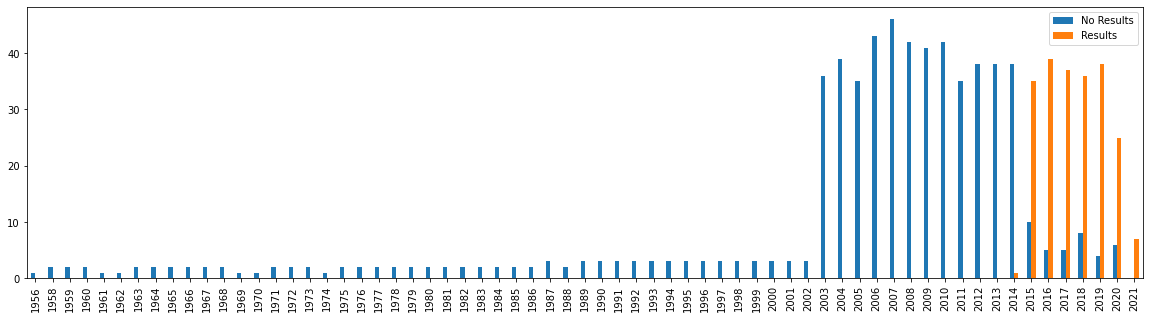

In [80]:
# plot counts of missing/not missing tournaments over time
tournament_seasons.plot(y=["No Results", "Results"], kind="bar",figsize=(20,5))
plt.show()
# three different types of tournament results distributions (see description in conclusion 2.)

In [81]:
def compare_missing_tournament_distribution_by_col_after_2013(column_name):
    missing_tournaments = tournament_df[(tournament_df['missing_results_flag'].notna()) & (tournament_df['season'] > 2013)]
    results_tournaments = tournament_df[(tournament_df['missing_results_flag'].isna())  & (tournament_df['season'] > 2013)]
    index = list(set(results_tournaments.groupby(column_name).count().index).union(set(missing_tournaments.groupby(column_name).count().index)))
    
    tournament_distribution = pd.DataFrame(columns=['No Results','Results'], index=index)
    tournament_distribution['No Results'] = missing_tournaments.groupby(column_name).count()['competition_ID']
    tournament_distribution['Results']    = results_tournaments.groupby(column_name).count()['competition_ID']

    tournament_distribution_percentage = pd.DataFrame(columns=['No Results','Results'])
    tournament_distribution_percentage['No Results'] = 100*missing_tournaments.groupby(column_name).count()['competition_ID']/missing_tournaments.shape[0]
    tournament_distribution_percentage['Results']    = 100*results_tournaments.groupby(column_name).count()['competition_ID']/results_tournaments.shape[0]

    return tournament_distribution, tournament_distribution_percentage

In [82]:
# compare distribution of category 
tournament_categories, tournament_categories_percents = compare_missing_tournament_distribution_by_col_after_2013('category')

print(tournament_categories)
print(tournament_categories_percents.applymap("{0:.1f}%".format))
# Missing lots more cadet by percentage and slightly less than vet by percentage 

          No Results  Results
Senior            23      115
Veterans           3       13
Cadet             31       12
Junior            19       78
         No Results Results
category                   
Cadet         40.8%    5.5%
Junior        25.0%   35.8%
Senior        30.3%   52.8%
Veterans       3.9%    6.0%


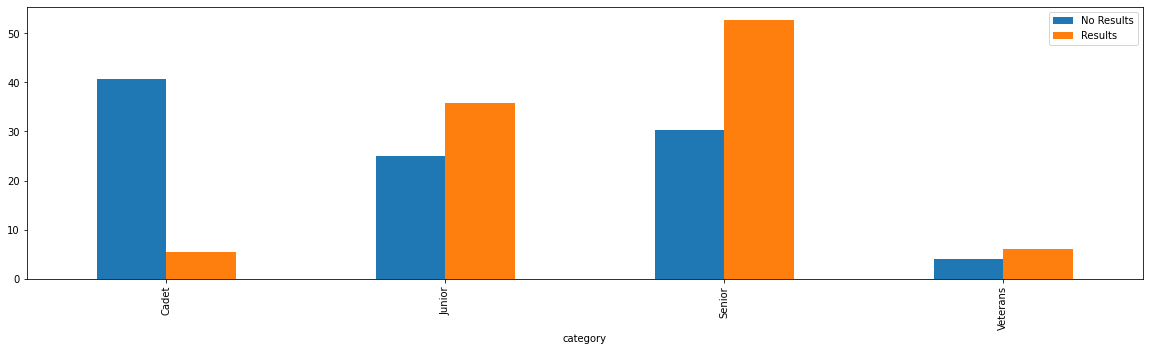

In [83]:
# plot counts of missing/not missing tournaments by age group
tournament_categories_percents.plot(y=["No Results", "Results"], kind="bar",figsize=(20,5))
plt.show()

In [89]:
# compare results reporting by country 
tournament_countries, tournament_countries_percent = compare_missing_tournament_distribution_by_col_after_2013('country')
tournament_countries.fillna(0, inplace=True)
tournament_countries = tournament_countries.astype(int)
print("Number of countries hosting tournaments after 2013: {}".format(tournament_countries.shape[0]))
tournament_countries['Percent w/ Results'] = 100* tournament_countries['Results'] / (tournament_countries['No Results']+tournament_countries['Results'])
tournament_countries.head()

Number of countries hosting tournaments after 2013: 58


,No Results,Results,Percent w/ Results
CHINA,2,8,80.0
BAHRAIN,1,1,50.0
CHINESE TAIPEI,0,1,100.0
GREAT BRITAIN,0,3,100.0
QATAR,0,1,100.0


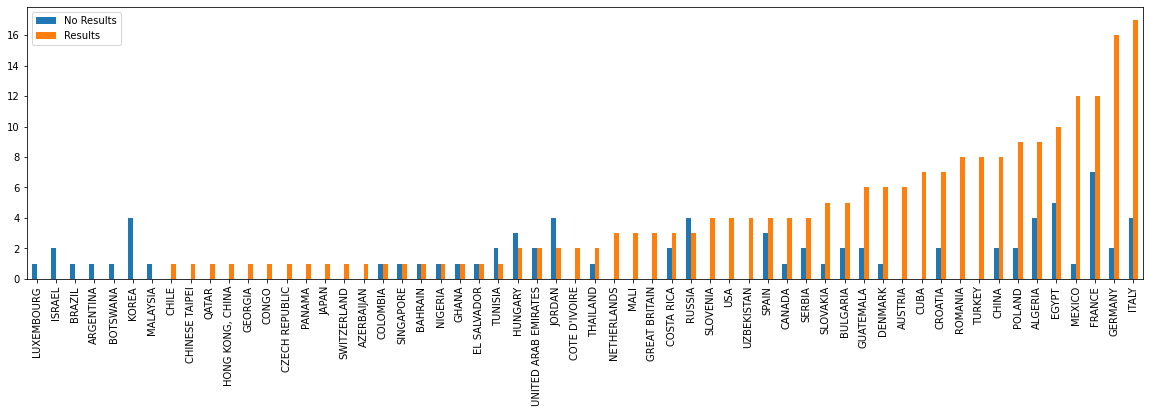

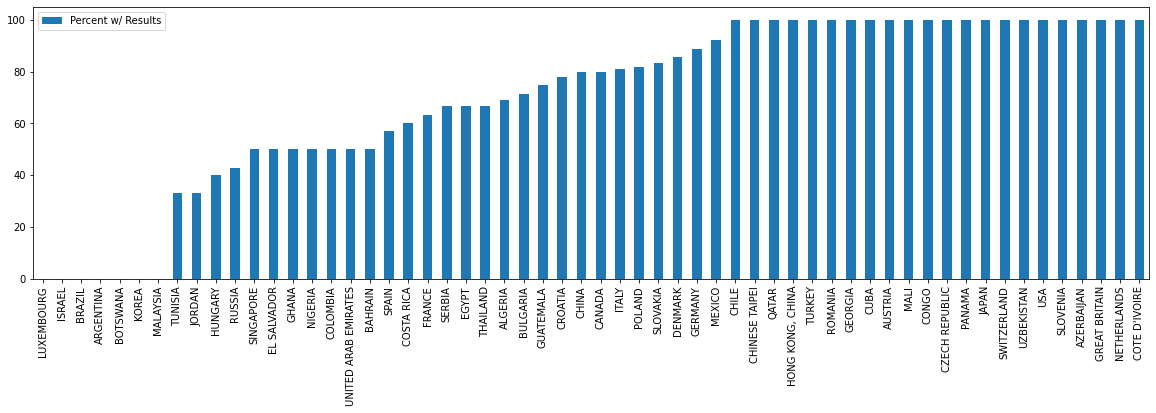

In [88]:
tournament_countries.sort_values(by='Results', inplace=True)
tournament_countries.plot(y=["No Results", "Results"], kind="bar",figsize=(20,5))
tournament_countries.sort_values(by='Percent w/ Results', inplace=True)
tournament_countries.plot(y=["Percent w/ Results"], kind="bar",figsize=(20,5))
plt.show()

In [ ]:
# should extract only tournaments post 2013 since all prior are missing (likely for technology reasons)

### Conclusions 

1. Two 'eras' of reporting for tournaments?
    * pre 2002 - very few tournaments listed on the FIE website, non with results data
    * 2002-2013 - lots of tournaments listed, but none with results for pools 
    * post 2013 - most tournaments have pools data recorded, some still missing 
2. In the post 2013 era, many cadet events are missing results (i.e. age group) 
3. By Country? Some countries have high reporting rates, others do not (from 0%-100%). 

### Conclusions

### Review ??? 

Look at 2020 and effect of COVID on tournaments? Did they still happen?

### Conclusions

## Review Missing Values 

In [30]:
list_of_df = [tournament_df, bout_df, fencer_bio_df, fencer_rankings_df]
for df in list_of_df:
    print("")
    print(df.df_name)
    print("")
    print("Columns: {}".format(list(df.columns)))
    print("  Row Count: {}".format(df.shape[0]))
    print("  Column Count: {}".format(df.shape[1]))


Tournament Dataframe

Columns: ['competition_ID', 'season', 'name', 'category', 'country', 'start_date', 'end_date', 'weapon', 'gender', 'timezone', 'url', 'unique_ID', 'missing_results_flag']
  Row Count: 830
  Column Count: 13

Bouts Dataframe

Columns: ['fencer_ID', 'opp_ID', 'fencer_age', 'opp_age', 'fencer_score', 'opp_score', 'winner_ID', 'fencer_curr_pts', 'opp_curr_pts', 'tournament_ID', 'pool_ID', 'upset', 'date']
  Row Count: 49131
  Column Count: 13

Fencer Bio Dataframe

Columns: ['id', 'name', 'country_code', 'country', 'hand', 'age', 'url', 'date_accessed']
  Row Count: 2108
  Column Count: 8

Fencer Rankings Dataframe

Columns: ['rank', 'points']
  Row Count: 10937
  Column Count: 2


In [31]:
# Should now have only 1 hand missing entry in fencer_bio_df
for df in list_of_df:
    print("")
    print(df.df_name)
    print("")

    print("Missing Values:",end="")
    if(df.isna().sum().sum() > 0):
        print("")
        print(df.isna().sum()[df.isna().sum() > 0])
    else:
        print("   None!")


Tournament Dataframe

Missing Values:
missing_results_flag    218
dtype: int64

Bouts Dataframe

Missing Values:   None!

Fencer Bio Dataframe

Missing Values:
hand    1
dtype: int64

Fencer Rankings Dataframe

Missing Values:   None!


### Save cleaned data

After processing data, store as new CSV files with 'processed' indicator